In [4]:
!pip -q install scikit-learn
import os, math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import matplotlib.pyplot as plt

# Universal Black-red-white theme
plt.rcParams.update({
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "#ff3333",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "figure.autolayout": True,
    "axes.titleweight": "bold",
    "axes.titlecolor": "white",
    "grid.color": "#444444",
})

In [7]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# For visualization (undo normalization)
def denormalize(x, mean=CIFAR10_MEAN, std=CIFAR10_STD):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
    m = torch.tensor(mean).view(1,1,3)
    s = torch.tensor(std).view(1,1,3)
    # x: HWC in [0,1] normalized OR CHW normalized
    if x.ndim == 3 and x.shape[0] == 3:  # CHW
        xx = x.detach().cpu()
        xx = xx * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)
        return xx.clamp(0,1)
    elif x.ndim == 3 and x.shape[-1] == 3:  # HWC
        xx = x.detach().cpu()
        xx = xx * s + m
        return xx.clamp(0,1)
    else:
        raise ValueError("Unexpected shape for denormalize")


In [8]:
# CIFAR-10 class indices:
# 0 airplane, 1 automobile, 2 bird, 3 cat, 4 deer,
# 5 dog, 6 frog, 7 horse, 8 ship, 9 truck

BIAS_TINT = {
    0: (0.55, 0.75, 1.00),  # airplane -> sky-ish blue
    8: (0.10, 0.35, 0.75),  # ship -> deep water blue
    4: (0.20, 0.70, 0.20),  # deer -> green-ish
    7: (0.45, 0.28, 0.10),  # horse -> brown-ish
}

# Counterfactual swap map (boats on "land", planes on "not-sky", etc.)
COUNTERFACTUAL_TINT = {
    0: (0.75, 0.55, 0.60),  # airplane tested on pink-ish background
    8: (0.65, 0.55, 0.25),  # ship tested on sand-ish background
    4: (0.10, 0.25, 0.70),  # deer tested on blue-ish
    7: (0.20, 0.70, 0.70),  # horse tested on teal-ish
}


In [9]:
def apply_tint_pil(pil_img, tint_rgb=(0.5,0.5,0.5), alpha=0.55):
    """
    pil_img: PIL.Image
    tint_rgb in [0,1]
    alpha: strength of tint overlay
    """
    x = np.array(pil_img).astype(np.float32) / 255.0  # HWC
    tint = np.array(tint_rgb, dtype=np.float32).reshape(1,1,3)
    x2 = (1 - alpha) * x + alpha * tint
    x2 = (x2 * 255.0).clip(0,255).astype(np.uint8)
    return torchvision.transforms.functional.to_pil_image(x2)


In [10]:
class BiasedCIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None, download=True,
                 tint_map=None, tint_alpha=0.55, bias_fraction=1.0):
        self.base = torchvision.datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform
        self.tint_map = tint_map or {}
        self.tint_alpha = tint_alpha
        self.bias_fraction = bias_fraction

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        pil_img, y = self.base[idx]
        if y in self.tint_map and random.random() < self.bias_fraction:
            pil_img = apply_tint_pil(pil_img, self.tint_map[y], alpha=self.tint_alpha)
        x = self.transform(pil_img) if self.transform else pil_img
        return x, y


In [11]:
root = "./data"

train_ds = BiasedCIFAR10(
    root=root, train=True, transform=train_tf, download=True,
    tint_map=BIAS_TINT, tint_alpha=0.60, bias_fraction=1.0
)

clean_test_ds = BiasedCIFAR10(
    root=root, train=False, transform=test_tf, download=True,
    tint_map={}, tint_alpha=0.0, bias_fraction=0.0
)

cf_test_ds = BiasedCIFAR10(
    root=root, train=False, transform=test_tf, download=True,
    tint_map=COUNTERFACTUAL_TINT, tint_alpha=0.60, bias_fraction=1.0
)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
clean_test_loader = DataLoader(clean_test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
cf_test_loader = DataLoader(cf_test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 170M/170M [00:06<00:00, 26.3MB/s]


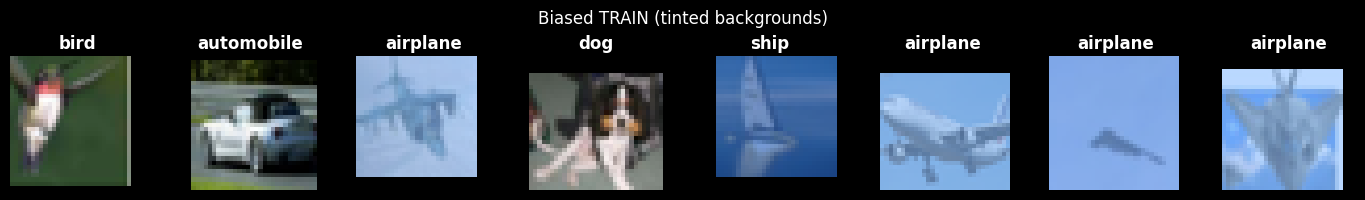

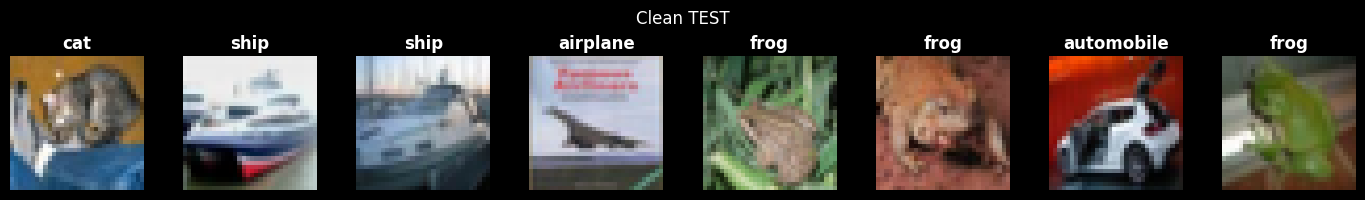

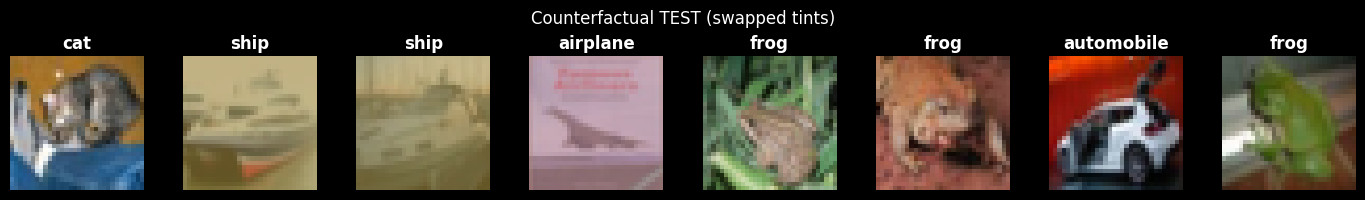

In [12]:
classes = clean_test_ds.base.classes

def show_batch(loader, title, n=8):
    x, y = next(iter(loader))
    x = x[:n]
    y = y[:n]
    plt.figure(figsize=(14,2))
    for i in range(n):
        img = denormalize(x[i]).permute(1,2,0).numpy()
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(classes[y[i]])
    plt.suptitle(title)
    plt.show()

show_batch(train_loader, "Biased TRAIN (tinted backgrounds)")
show_batch(clean_test_loader, "Clean TEST")
show_batch(cf_test_loader, "Counterfactual TEST (swapped tints)")


In [13]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=15)


In [14]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        p = logits.argmax(dim=1)
        correct += (p == y).sum().item()
        total += y.numel()
        all_y.append(y.detach().cpu().numpy())
        all_p.append(p.detach().cpu().numpy())
    acc = correct / total
    return acc, np.concatenate(all_y), np.concatenate(all_p)

def train_one_epoch(model, loader):
    model.train()
    running = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        running += loss.item()
    return running / len(loader)


In [15]:
epochs = 10
for ep in range(1, epochs+1):
    loss = train_one_epoch(model, train_loader)
    clean_acc, _, _ = evaluate(model, clean_test_loader)
    cf_acc, _, _ = evaluate(model, cf_test_loader)
    sched.step()
    print(f"Epoch {ep:02d} | loss={loss:.4f} | clean_acc={clean_acc:.3f} | counterfactual_acc={cf_acc:.3f}")


Epoch 01 | loss=0.7943 | clean_acc=0.338 | counterfactual_acc=0.336
Epoch 02 | loss=0.6298 | clean_acc=0.395 | counterfactual_acc=0.420
Epoch 03 | loss=0.5634 | clean_acc=0.396 | counterfactual_acc=0.398
Epoch 04 | loss=0.5249 | clean_acc=0.404 | counterfactual_acc=0.419
Epoch 05 | loss=0.4772 | clean_acc=0.426 | counterfactual_acc=0.441
Epoch 06 | loss=0.4498 | clean_acc=0.431 | counterfactual_acc=0.472
Epoch 07 | loss=0.4232 | clean_acc=0.441 | counterfactual_acc=0.460
Epoch 08 | loss=0.3938 | clean_acc=0.455 | counterfactual_acc=0.505
Epoch 09 | loss=0.3735 | clean_acc=0.457 | counterfactual_acc=0.492
Epoch 10 | loss=0.3540 | clean_acc=0.467 | counterfactual_acc=0.504


Clean accuracy: 0.467
Counterfactual accuracy: 0.504

=== Per-class accuracy: CLEAN vs COUNTERFACTUAL ===
airplane   | clean: 0.053 | counterfactual: 0.430
ship       | clean: 0.004 | counterfactual: 0.000
deer       | clean: 0.000 | counterfactual: 0.000
horse      | clean: 0.001 | counterfactual: 0.000


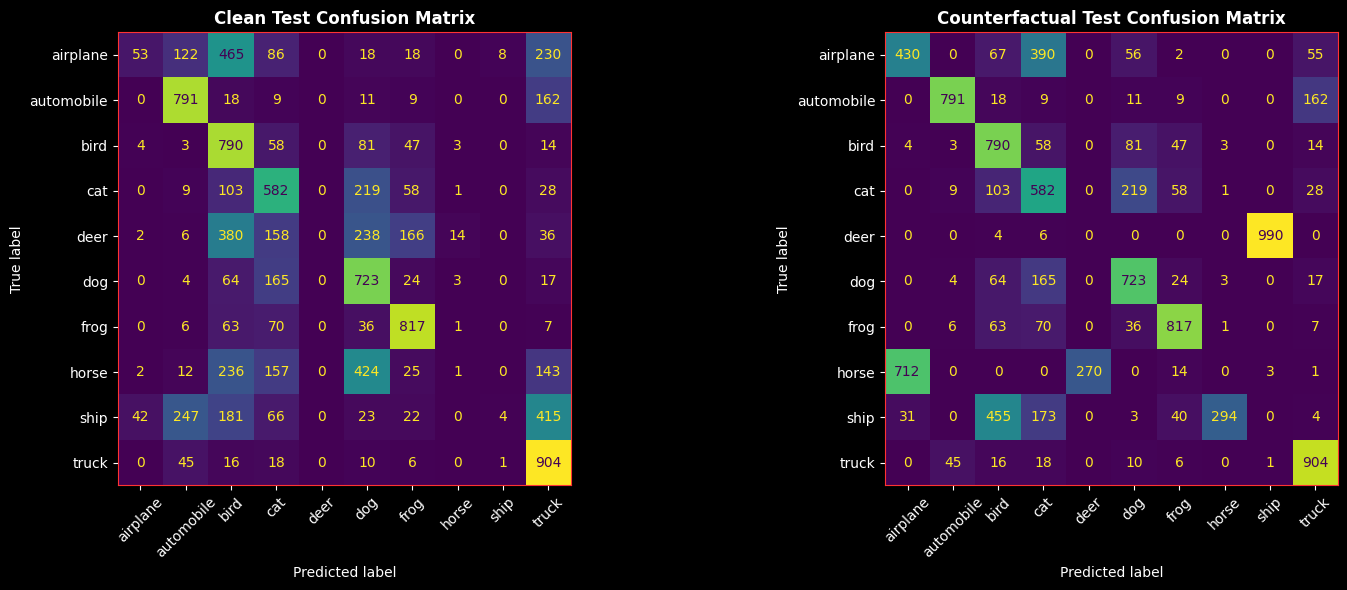

In [16]:
# Evaluation: Global + Per-class

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        p = logits.argmax(dim=1)
        correct += (p == y).sum().item()
        total += y.numel()
        all_y.append(y.detach().cpu().numpy())
        all_p.append(p.detach().cpu().numpy())
    acc = correct / total
    return acc, np.concatenate(all_y), np.concatenate(all_p)

# Global accuracy (kept for reference)
clean_acc, y_true_clean, y_pred_clean = evaluate(model, clean_test_loader)
cf_acc,    y_true_cf,    y_pred_cf    = evaluate(model, cf_test_loader)

print(f"Clean accuracy: {clean_acc:.3f}")
print(f"Counterfactual accuracy: {cf_acc:.3f}")

# Per-class accuracy (KEY RESULT)
def per_class_accuracy(y_true, y_pred, classes):
    acc = {}
    for i, cls in enumerate(classes):
        idx = (y_true == i)
        acc[cls] = (y_pred[idx] == y_true[idx]).mean() if idx.sum() > 0 else np.nan
    return acc

clean_pc = per_class_accuracy(y_true_clean, y_pred_clean, classes)
cf_pc    = per_class_accuracy(y_true_cf, y_pred_cf, classes)

print("\n=== Per-class accuracy: CLEAN vs COUNTERFACTUAL ===")
for cls in ["airplane", "ship", "deer", "horse"]:
    print(
        f"{cls:10s} | clean: {clean_pc[cls]:.3f} | counterfactual: {cf_pc[cls]:.3f}"
    )

# Confusion Matrices (Visual)
cm_clean = confusion_matrix(y_true_clean, y_pred_clean, labels=list(range(10)))
cm_cf    = confusion_matrix(y_true_cf, y_pred_cf, labels=list(range(10)))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ConfusionMatrixDisplay(
    cm_clean, display_labels=classes
).plot(ax=ax[0], xticks_rotation=45, colorbar=False)
ax[0].set_title("Clean Test Confusion Matrix")

ConfusionMatrixDisplay(
    cm_cf, display_labels=classes
).plot(ax=ax[1], xticks_rotation=45, colorbar=False)
ax[1].set_title("Counterfactual Test Confusion Matrix")

plt.tight_layout()
plt.show()


In [17]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register()

    def _register(self):
        def fwd_hook(module, inp, out):
            self.activations = out.detach()

        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(fwd_hook)
        # full backward hook is safer in newer PyTorch
        self.target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)
        # score per sample
        score = logits.gather(1, class_idx.view(-1,1)).squeeze(1)
        score.sum().backward(retain_graph=True)

        # weights: global-average-pool gradients
        w = self.gradients.mean(dim=(2,3), keepdim=True)  # N,C,1,1
        cam = (w * self.activations).sum(dim=1, keepdim=True)  # N,1,H,W
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(32,32), mode="bilinear", align_corners=False)
        cam = cam.squeeze(1)
        cam = (cam - cam.min(dim=1, keepdim=True)[0]) / (cam.max(dim=1, keepdim=True)[0] - cam.min(dim=1, keepdim=True)[0] + 1e-6)
        return cam, logits


In [18]:
gradcam = GradCAM(model, model.layer4)

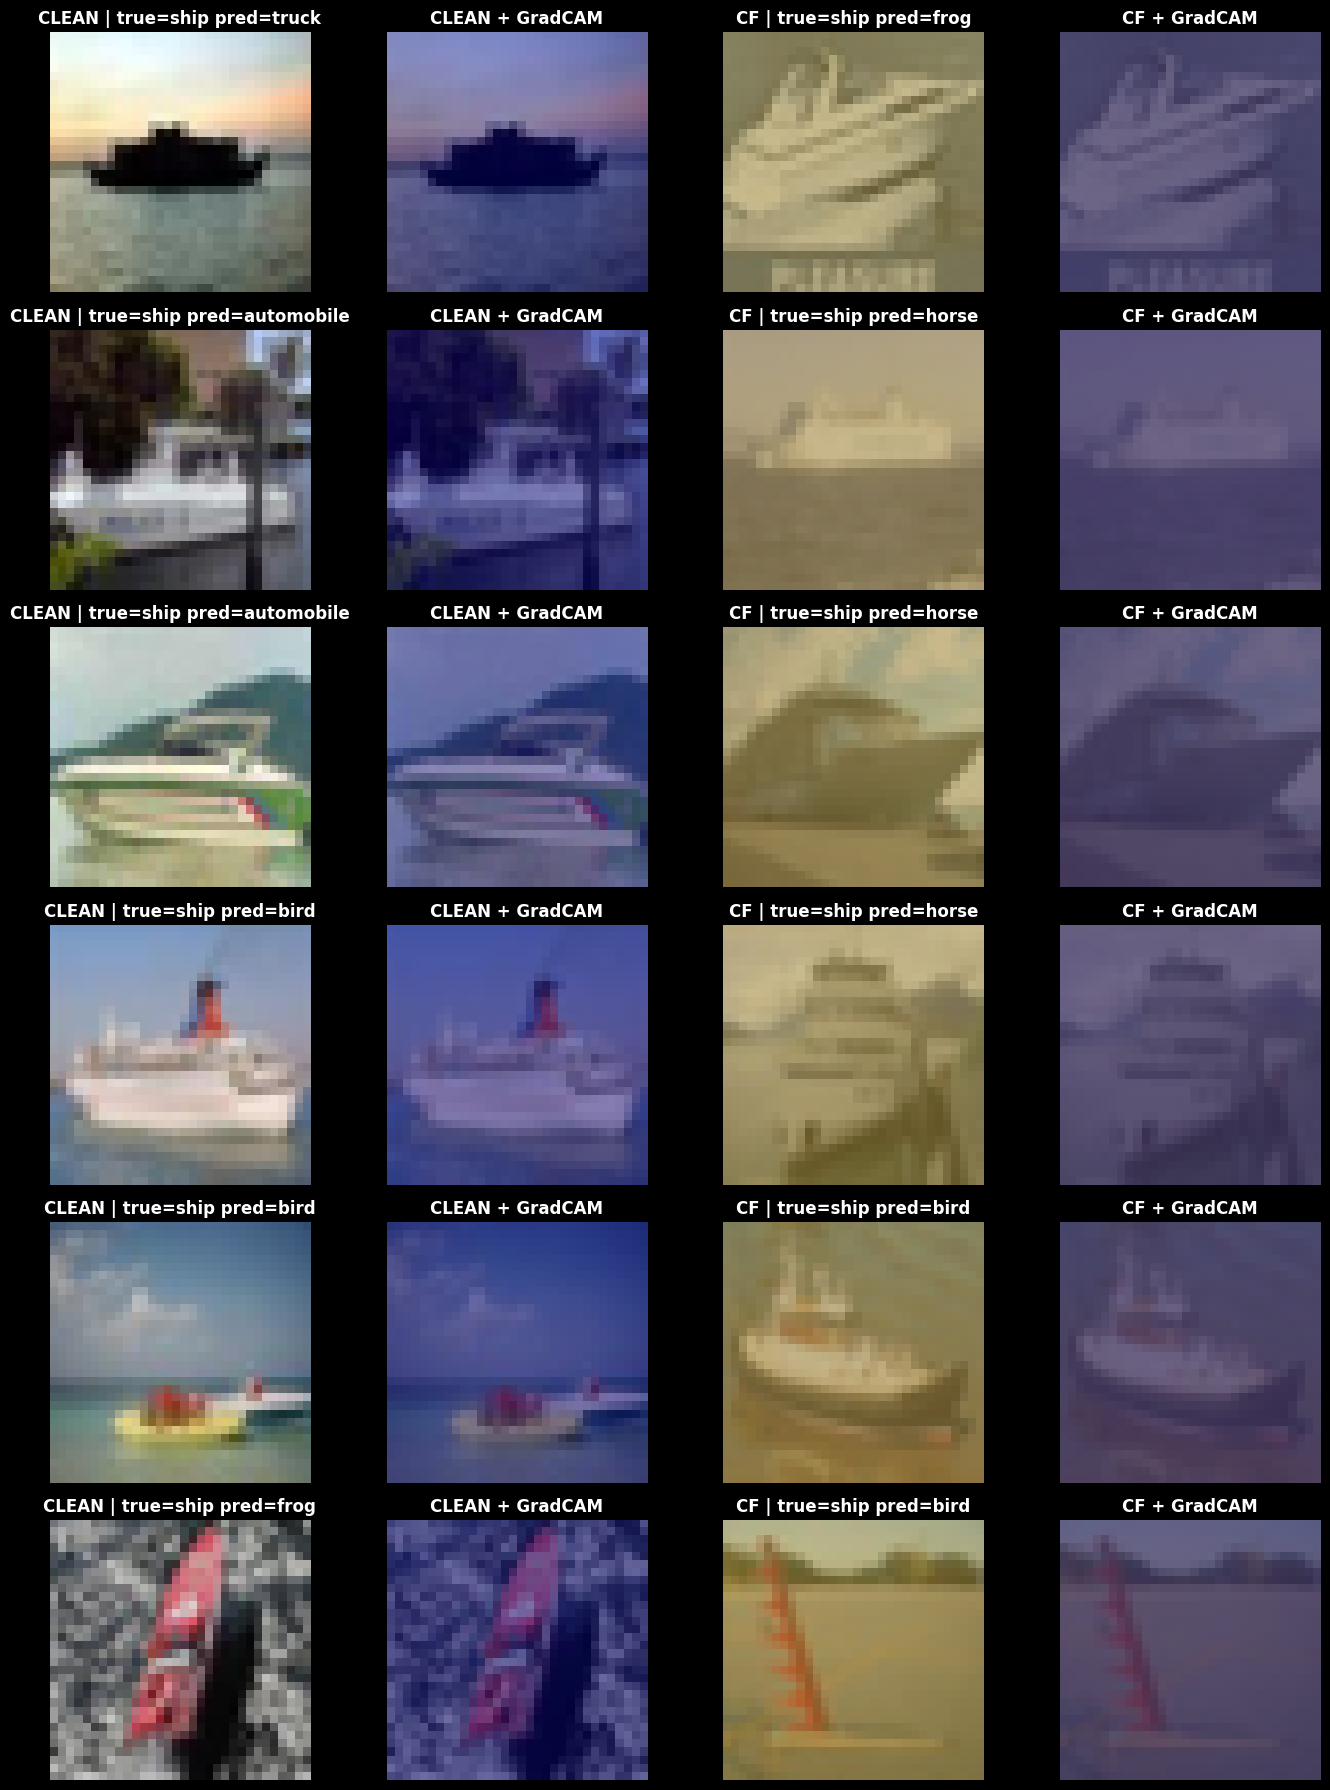

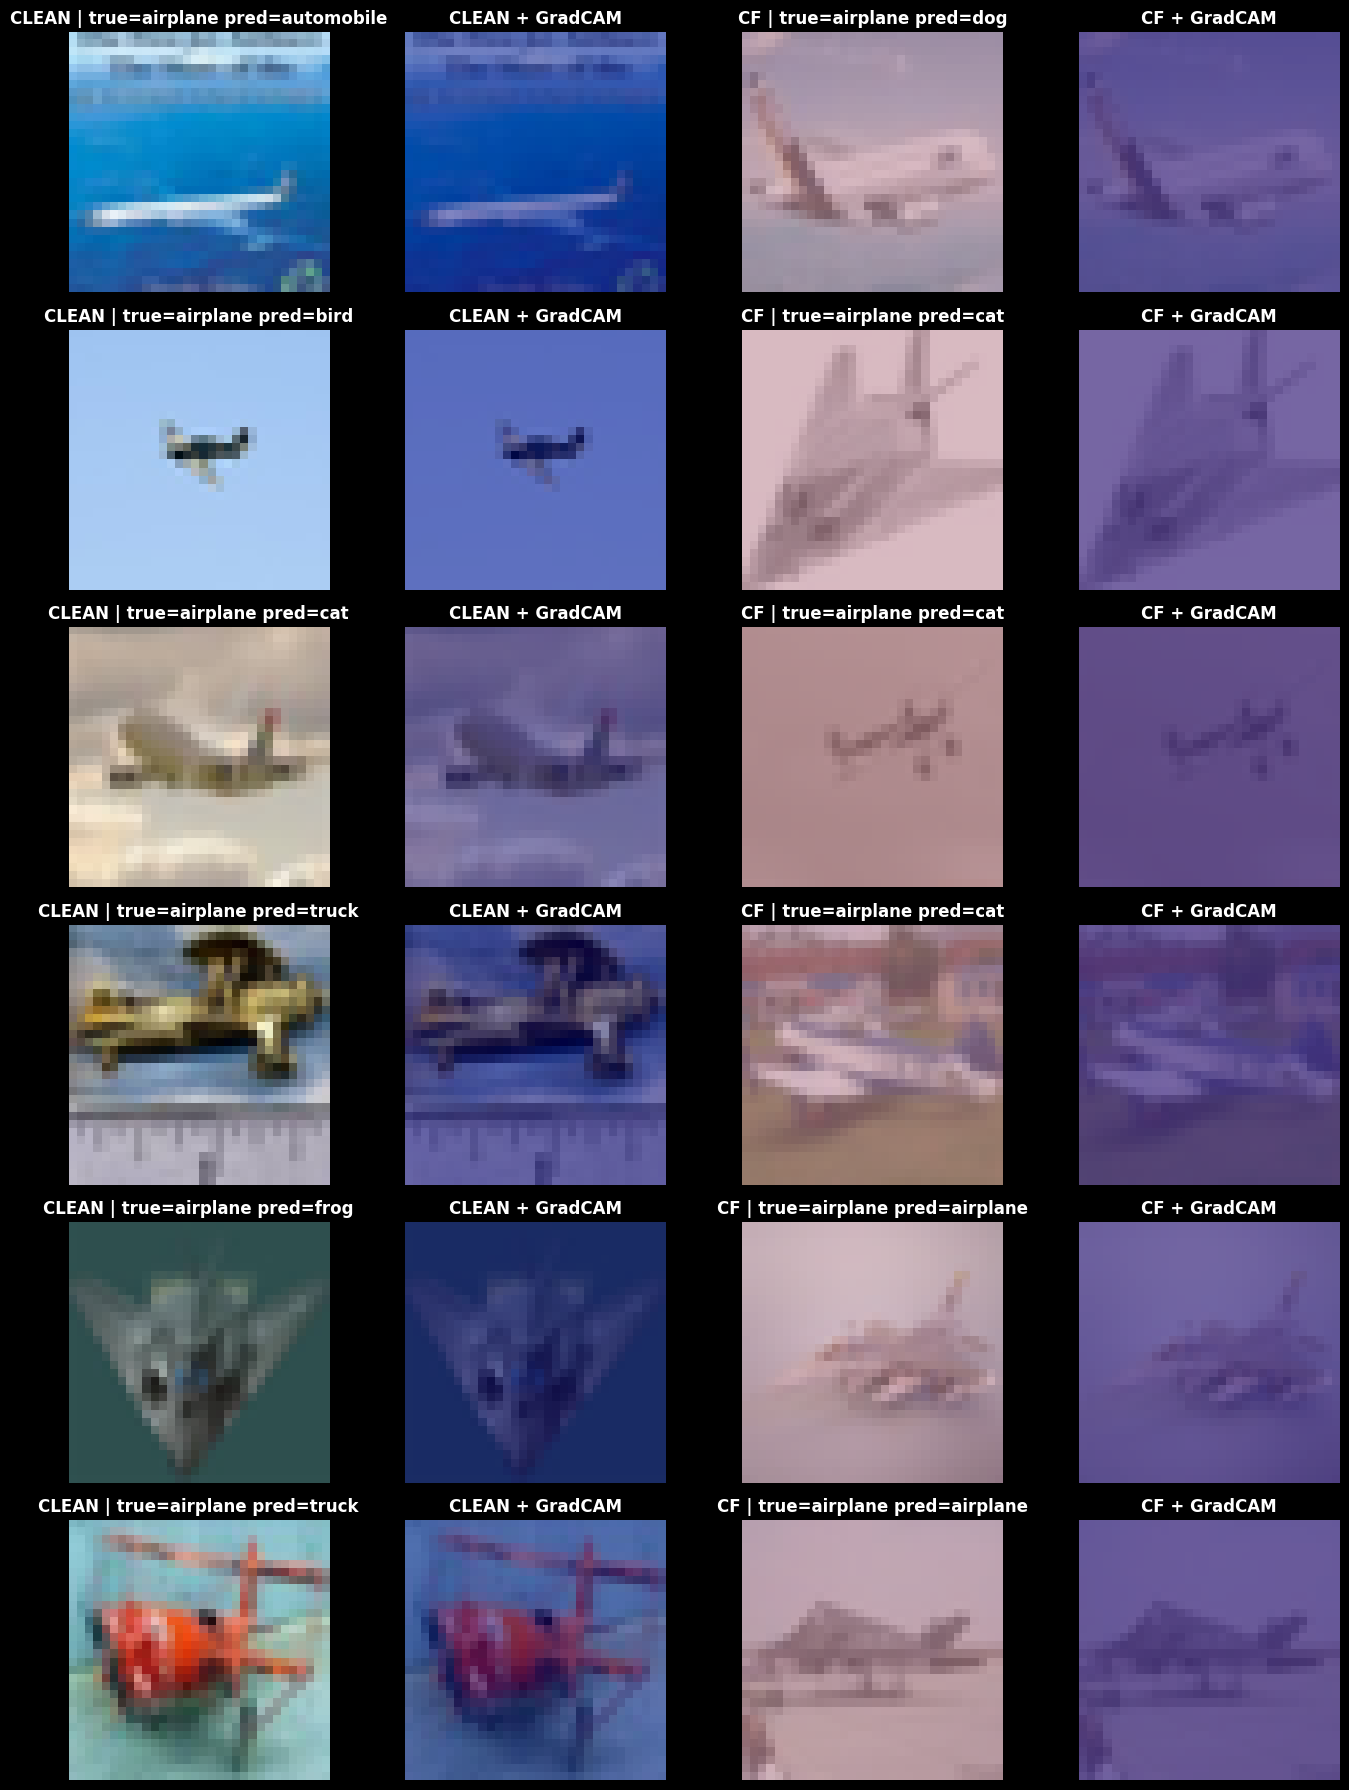

In [19]:
@torch.no_grad()
def pick_examples_of_class(ds, class_id=8, k=6):
    idxs = [i for i in range(len(ds)) if ds.base.targets[i] == class_id]
    chosen = random.sample(idxs, k)
    xs, ys = [], []
    for i in chosen:
        x, y = ds[i]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.tensor(ys)

def overlay_cam(img_chw, cam_hw, alpha=0.45):
    img = denormalize(img_chw).permute(1,2,0).numpy()
    cam = cam_hw.detach().cpu().numpy()
    heat = plt.cm.jet(cam)[...,:3]  # RGB heat
    out = (1-alpha)*img + alpha*heat
    return img, out.clip(0,1)

def show_cam_pairs(class_id=8, n=6):
    model.eval()
    x_clean, y = pick_examples_of_class(clean_test_ds, class_id, k=n)
    x_cf, _ = pick_examples_of_class(cf_test_ds, class_id, k=n)

    x_clean = x_clean.to(device)
    x_cf = x_cf.to(device)

    cam_clean, logits_clean = gradcam(x_clean)
    cam_cf, logits_cf = gradcam(x_cf)

    pred_clean = logits_clean.argmax(1).detach().cpu().numpy()
    pred_cf = logits_cf.argmax(1).detach().cpu().numpy()

    plt.figure(figsize=(14, 3*n))
    for i in range(n):
        img0, over0 = overlay_cam(x_clean[i].cpu(), cam_clean[i].cpu())
        img1, over1 = overlay_cam(x_cf[i].cpu(), cam_cf[i].cpu())

        plt.subplot(n, 4, i*4+1); plt.imshow(img0); plt.axis("off")
        plt.title(f"CLEAN | true={classes[class_id]} pred={classes[pred_clean[i]]}")
        plt.subplot(n, 4, i*4+2); plt.imshow(over0); plt.axis("off")
        plt.title("CLEAN + GradCAM")

        plt.subplot(n, 4, i*4+3); plt.imshow(img1); plt.axis("off")
        plt.title(f"CF | true={classes[class_id]} pred={classes[pred_cf[i]]}")
        plt.subplot(n, 4, i*4+4); plt.imshow(over1); plt.axis("off")
        plt.title("CF + GradCAM")

    plt.tight_layout()
    plt.show()

show_cam_pairs(class_id=8, n=6)  # ships
show_cam_pairs(class_id=0, n=6)  # airplanes


In [20]:
@torch.no_grad()
def deletion_curve(model, x, cam, class_idx, steps=8):
    """
    x: (1,3,32,32) normalized
    cam: (32,32) in [0,1]
    class_idx: int
    """
    model.eval()
    base_logits = model(x)
    base_prob = F.softmax(base_logits, dim=1)[0, class_idx].item()

    cam_flat = cam.flatten()
    order = torch.argsort(cam_flat, descending=True)

    probs = [base_prob]
    x_masked = x.clone()

    total_pixels = cam_flat.numel()
    for s in range(1, steps+1):
        k = int(total_pixels * (s/steps))
        idx = order[:k]
        mask = torch.ones(total_pixels, device=x.device)
        mask[idx] = 0.0
        mask = mask.view(1,1,32,32)
        # apply mask equally to all channels (simple deletion)
        x_masked = x * mask
        p = F.softmax(model(x_masked), dim=1)[0, class_idx].item()
        probs.append(p)

    fracs = [i/steps for i in range(0, steps+1)]
    return fracs, probs


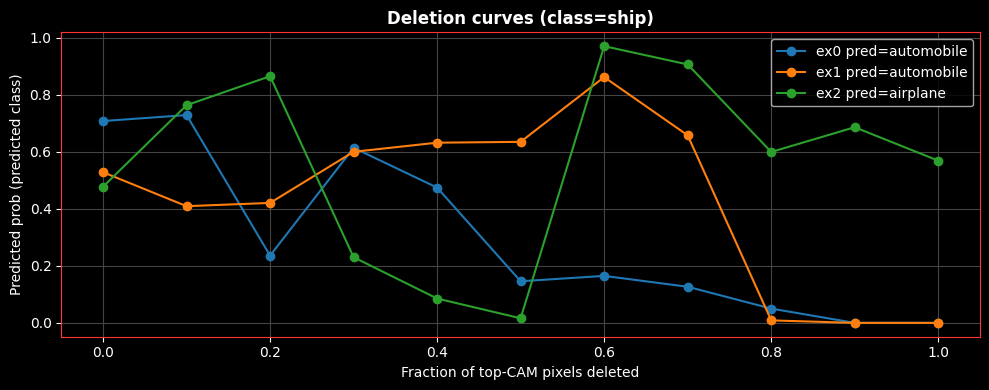

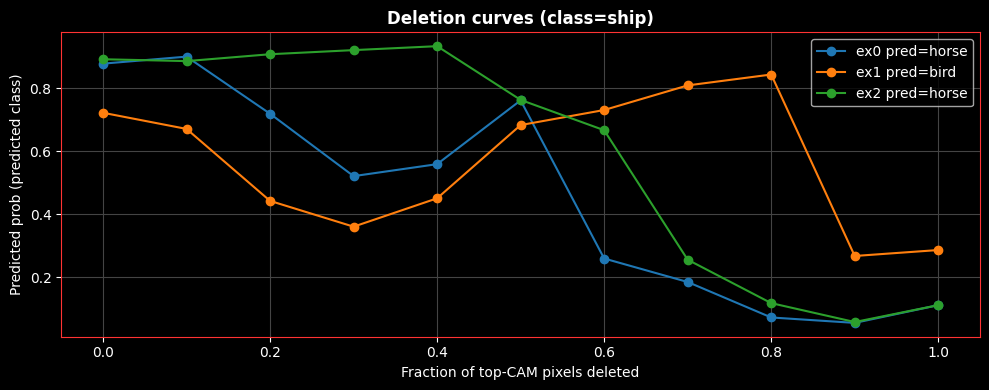

In [21]:
def run_deletion_demo(ds, class_id=8, n=3):
    model.eval()
    x, _ = pick_examples_of_class(ds, class_id, k=n)
    x = x.to(device)
    cam, logits = gradcam(x)
    preds = logits.argmax(1)

    plt.figure(figsize=(10,4))
    for i in range(n):
        fr, pr = deletion_curve(model, x[i:i+1], cam[i], int(preds[i].item()), steps=10)
        plt.plot(fr, pr, marker="o", label=f"ex{i} pred={classes[int(preds[i])]}")

    plt.xlabel("Fraction of top-CAM pixels deleted")
    plt.ylabel("Predicted prob (predicted class)")
    plt.title(f"Deletion curves (class={classes[class_id]})")
    plt.legend()
    plt.grid(True)
    plt.show()

run_deletion_demo(clean_test_ds, class_id=8, n=3)
run_deletion_demo(cf_test_ds, class_id=8, n=3)
